Import the used libraries:

In [1]:
import requests
from requests.exceptions import HTTPError

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('seaborn')

## The Data Set

The data used in this notebook is retrieved from the HTTP API created by Jan-Philip Gehrcke (https://gehrcke.de/).   
To read all about the data sources and the API, check out this GitHub Repository: https://github.com/jgehrcke/covid-19-germany-gae#attribution   

As a summary:

*These are official numbers published by individual state health ministries in Germany. The numbers from the individual (hundreds of) public German health offices (Gesundheitsämter) are first collected and aggregated on the state level, by the individual state health ministries. From here, they are further collected and published through "situation reports" by the Robert Koch-Institut (yielding the data points in this database before March 17), but also by ZEIT ONLINE (yielding the data points in my database from March 17 on).*

*The dataset includes historical data for individual Bundesländer (states). Manually curated from RKI "situation reports", until March 17. Since then, based on the more up-to-date reports by the individual states themselves. To my knowledge that is unique and the main reason I started this project.*

Prepare a DataFrame with the States and Links:

In [2]:
state_codes = ['DE-BW','DE-BY','DE-BE','DE-BB','DE-HB','DE-HH','DE-HE','DE-MV','DE-NI','DE-NW','DE-RP','DE-SL','DE-SN','DE-ST','DE-SH','DE-TH']
state_names = ['Baden-Württemberg', 'Bavaria', 'Berlin', 'Brandenburg', 'Bremen', 'Hamburg', 'Hesse', 'Mecklenburg-Western Pomerania', 'Lower Saxony', 'North Rhine-Westphalia', 'Rhineland-Palatinate',
         'Saarland', 'Saxony', 'Saxony-Anhalt', 'Schleswig-Holstein', 'Thuringia']
metrics = ['cases', 'deaths']

In [3]:
cases_links = ['https://covid19-germany.appspot.com/timeseries/{}/cases'.format(state_code) for state_code in state_codes]
deaths_links = ['https://covid19-germany.appspot.com/timeseries/{}/deaths'.format(state_code) for state_code in state_codes]

In [4]:
links = pd.DataFrame( {'StateName' : state_names, 'StateCode' : state_codes, 'CasesLink' : cases_links, 'DeathsLink' : deaths_links})

Make the HTML requests to get the data:

First extract the Cases Data from the API:

In [5]:
cases_data = {}

for (state_name, cases_link) in zip(links['StateName'], links['CasesLink']):
    
    try:
        response = requests.get(cases_link)
        
        data = response.json()['data']
        
        dates = []
        cases = []
        for row in data:
            cases.append(list(row.values())[0])
            for key in row:
                dates.append(key)
                
        result_for_state = [dates, cases]
        
        cases_data[str(state_name)] = result_for_state

        # If the response was successful, no Exception will be raised
        response.raise_for_status()
    except HTTPError as http_err:
        print(f'HTTP error occurred for {state_name}: {http_err}')
    except Exception as err:
        print(f'Other error occurred for {state_name}: {err}') 
    else:
        print(f'Success for {state_name}!')
        

cases_data_final = pd.DataFrame()

for key in cases_data:
    series = pd.Series( cases_data[key][1], index=cases_data[key][0] )
    cases_data_final[key] = series

Success for Baden-Württemberg!
Success for Bavaria!
Success for Berlin!
Success for Brandenburg!
Success for Bremen!
Success for Hamburg!
Success for Hesse!
Success for Mecklenburg-Western Pomerania!
Success for Lower Saxony!
Success for North Rhine-Westphalia!
Success for Rhineland-Palatinate!
Success for Saarland!
Success for Saxony!
Success for Saxony-Anhalt!
Success for Schleswig-Holstein!
Success for Thuringia!


Next the extract the data about the number of deaths:

In [6]:
deaths_data = {}

for (state_name, deaths_link) in zip(links['StateName'], links['DeathsLink']):
    
    try:
        response = requests.get(deaths_link)
        
        data = response.json()['data']
        
        dates = []
        deaths = []
        for row in data:
            deaths.append(list(row.values())[0])
            for key in row:
                dates.append(key)
                
        result_for_state = [dates, deaths]
        
        deaths_data[str(state_name)] = result_for_state

        # If the response was successful, no Exception will be raised
        response.raise_for_status()
    except HTTPError as http_err:
        print(f'HTTP error occurred for {state_name}: {http_err}')
    except Exception as err:
        print(f'Other error occurred for {state_name}: {err}') 
    else:
        print(f'Success for {state_name}!')
        

deaths_data_final = pd.DataFrame()

for key in deaths_data:
    series = pd.Series( deaths_data[key][1], index=deaths_data[key][0] )
    deaths_data_final[key] = series

Success for Baden-Württemberg!
Success for Bavaria!
Success for Berlin!
Success for Brandenburg!
Success for Bremen!
Success for Hamburg!
Success for Hesse!
Success for Mecklenburg-Western Pomerania!
Success for Lower Saxony!
Success for North Rhine-Westphalia!
Success for Rhineland-Palatinate!
Success for Saarland!
Success for Saxony!
Success for Saxony-Anhalt!
Success for Schleswig-Holstein!
Success for Thuringia!


Combine the data about cases and the data about deaths in a multiindex dataframe:

In [7]:
data_final = pd.concat({'Cases':cases_data_final, 'Deaths':deaths_data_final }, axis=1)
data_final.index = pd.to_datetime(pd.to_datetime(data_final.index).date)
data_final['Cases', 'Total'] = data_final['Cases'].sum(axis=1)
data_final['Deaths', 'Total'] = data_final['Deaths'].sum(axis=1)

# Germany

In [8]:
last_date = data_final.index[-1].strftime('%Y-%m-%d')
second_last_date = data_final.index[-2].strftime('%Y-%m-%d')
total_cases_germany_last_date = data_final['Cases', 'Total'].iloc[-1]
total_cases_germany_second_last_date = data_final['Cases', 'Total'].iloc[-2]
growth_rate_cases = ((total_cases_germany_last_date/total_cases_germany_second_last_date) - 1) * 100
print(f'On {last_date} there were a total of {total_cases_germany_last_date:,} COVID-19 cases in Germany.')
print(f'On the day before ({second_last_date}) there were a total of {total_cases_germany_second_last_date:,} COVID-19 cases in Germany')
print(f'This is a growth rate of {growth_rate_cases:.2f}%.\n')

total_deaths_germany_last_date = data_final['Deaths', 'Total'].iloc[-1]
total_deaths_germany_second_last_date = data_final['Deaths', 'Total'].iloc[-2]
growth_rate_deaths = ((total_deaths_germany_last_date/total_deaths_germany_second_last_date) - 1) * 100
print(f'On {last_date} there were a total of {total_deaths_germany_last_date:,} COVID-19 attributed deaths in Germany.')
print(f'On the day before ({second_last_date}) there were a total of {total_deaths_germany_second_last_date:,} COVID-19 attributed deaths in Germany')
print(f'This is a growth rate of {growth_rate_deaths:.2f}%.\n')

On 2020-03-23 there were a total of 28,942 COVID-19 cases in Germany.
On the day before (2020-03-22) there were a total of 24,273 COVID-19 cases in Germany
This is a growth rate of 19.24%.

On 2020-03-23 there were a total of 122 COVID-19 attributed deaths in Germany.
On the day before (2020-03-22) there were a total of 92 COVID-19 attributed deaths in Germany
This is a growth rate of 32.61%.



## Linear Scale:

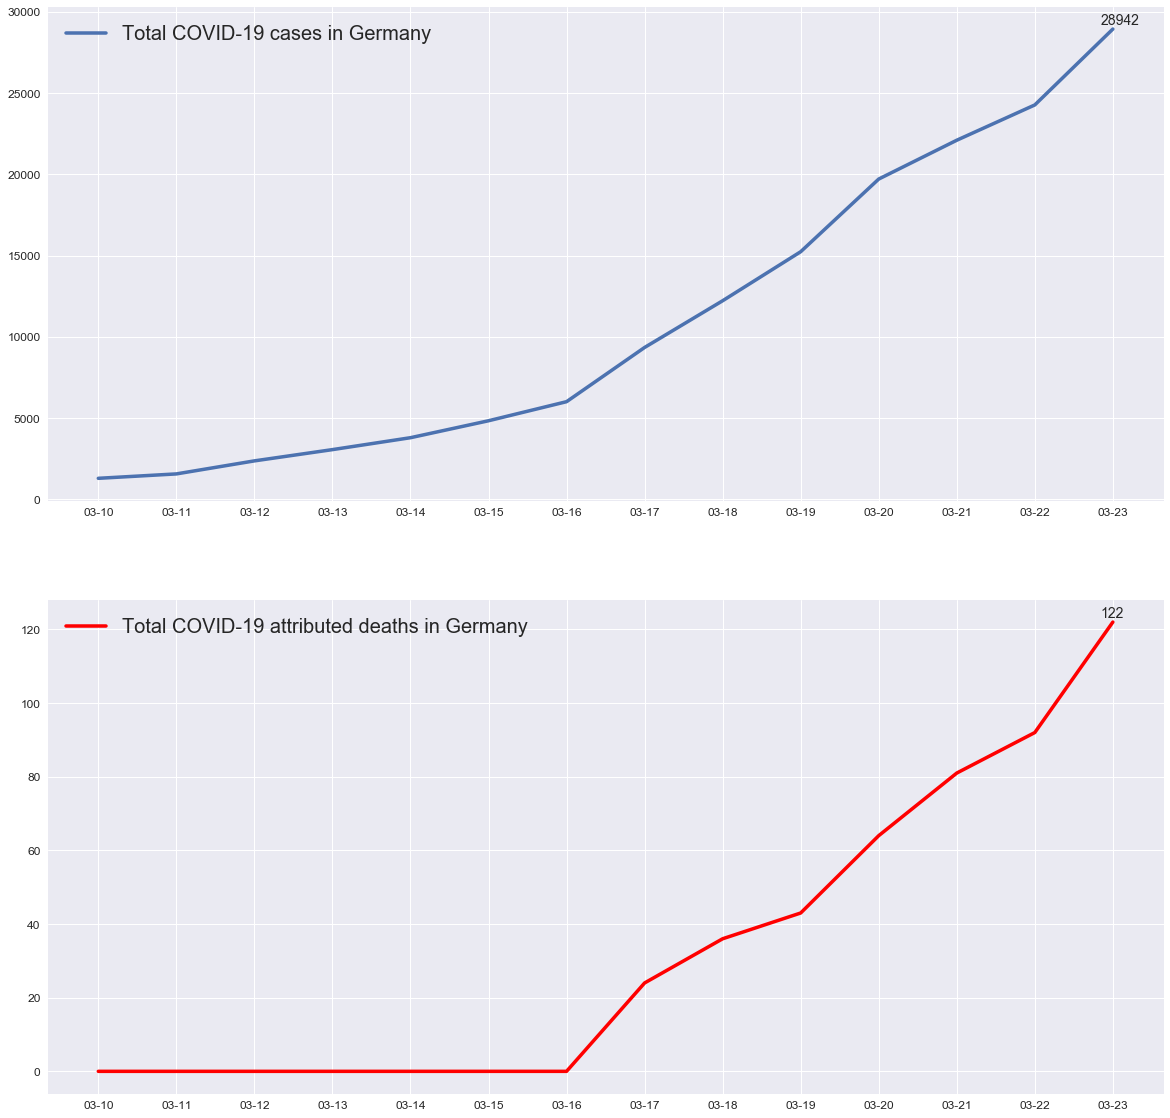

In [9]:
fig, axes = plt.subplots(2,1, figsize=(20,20))

date_locator = mdates.DayLocator()
date_formatter = mdates.DateFormatter('%m-%d')

#cases
axes[0].plot(data_final.index, data_final['Cases', 'Total'], linewidth=3.5, label='Total COVID-19 cases in Germany')

axes[0].legend(loc='upper left', fontsize=20)
axes[0].xaxis.set_major_locator(date_locator)
axes[0].xaxis.set_major_formatter(date_formatter)
axes[0].tick_params(axis='y', which='both', labelsize=12)
axes[0].tick_params(axis='x', which='both', labelsize=12)

axes[0].annotate(total_cases_germany_last_date, xy=(data_final.index[-1], total_cases_germany_last_date), xytext=(-12,5), textcoords='offset points', size=14)

#deaths
axes[1].plot(data_final.index, data_final['Deaths', 'Total'], linewidth=3.5, label='Total COVID-19 attributed deaths in Germany', color='r')

axes[1].legend(loc='upper left', fontsize=20)
axes[1].xaxis.set_major_locator(date_locator)
axes[1].xaxis.set_major_formatter(date_formatter)
axes[1].tick_params(axis='y', which='both', labelsize=12)
axes[1].tick_params(axis='x', which='both', labelsize=12)

axes[1].annotate(total_deaths_germany_last_date, xy=(data_final.index[-1], total_deaths_germany_last_date), xytext=(-12,5), textcoords='offset points', size=14);

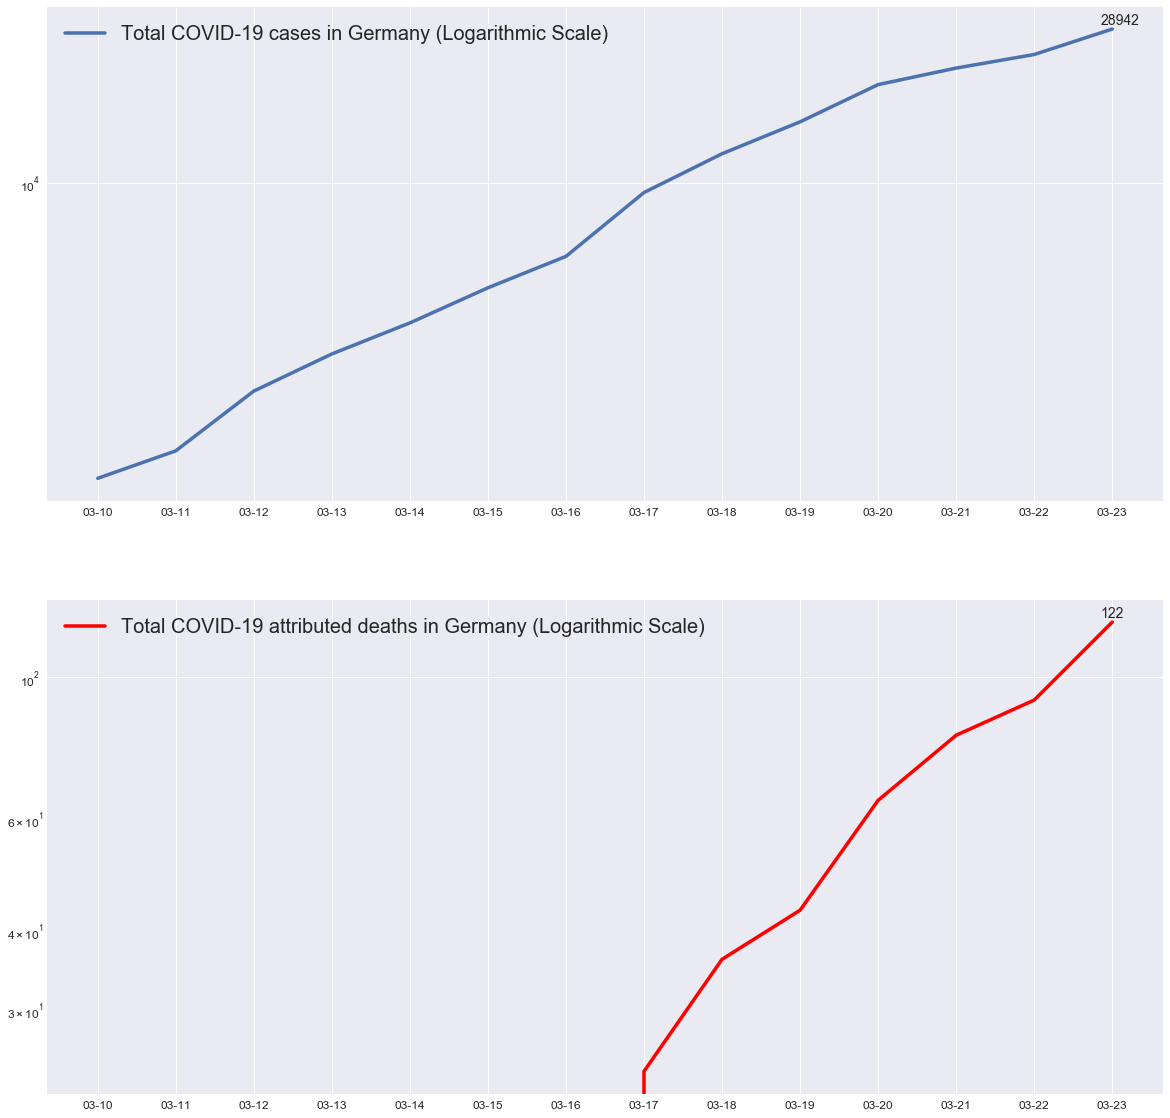

In [10]:
fig, axes = plt.subplots(2,1, figsize=(20,20))

date_locator = mdates.DayLocator()
date_formatter = mdates.DateFormatter('%m-%d')

#cases
axes[0].set_yscale('log')
axes[0].plot(data_final.index, data_final['Cases', 'Total'], linewidth=3.5, label='Total COVID-19 cases in Germany (Logarithmic Scale)')

axes[0].legend(loc='upper left', fontsize=20)
axes[0].xaxis.set_major_locator(date_locator)
axes[0].xaxis.set_major_formatter(date_formatter)
axes[0].tick_params(axis='y', which='both', labelsize=12)
axes[0].tick_params(axis='x', which='both', labelsize=12)

axes[0].annotate(total_cases_germany_last_date, xy=(data_final.index[-1], total_cases_germany_last_date), xytext=(-12,5), textcoords='offset points', size=14)

#deaths
axes[1].set_yscale('log')
axes[1].plot(data_final.index, data_final['Deaths', 'Total'], linewidth=3.5, label='Total COVID-19 attributed deaths in Germany (Logarithmic Scale)', color='r')

axes[1].legend(loc='upper left', fontsize=20)
axes[1].xaxis.set_major_locator(date_locator)
axes[1].xaxis.set_major_formatter(date_formatter)
axes[1].tick_params(axis='y', which='both', labelsize=12)
axes[1].tick_params(axis='x', which='both', labelsize=12)

axes[1].annotate(total_deaths_germany_last_date, xy=(data_final.index[-1], total_deaths_germany_last_date), xytext=(-12,5), textcoords='offset points', size=14);